In [1]:
"""
XGBOOST Experiments Serrano/AUDSOME Phase 1
Gabriel Iuhasz

Single Model experiment based on HPO optimization

Anomaly Only
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from subprocess import check_output
# from sklearn.externals import joblib
from joblib import dump, load
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline

# TODO check deprecation warning xgboost
import warnings
warnings.filterwarnings('ignore')

print("Checking files in data location ...")
train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models
processed



In [2]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)


def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, target_names=definitions))
    report = classification_report(y, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)

def save_valid_curve_scores(viz, param, param_range, fname):
    """
    :param viz: yellowbrick viz object
    :param param: parameter name used in validation curve
    :param fname: mL_method used
    :return: dataframe with crossvalidation scores for param and param range set by user
    """
    columns = []
    for f in range(viz.cv.n_splits):
        columns.append(f"Fold{f}")
    scores = viz.test_scores_
    df_scores = pd.DataFrame(scores, index=param_range, columns=columns)
    df_scores.to_csv(os.path.join(model_dir, f"{fname}_{param}_validationcurve_scores.csv"))
    return df_scores

Setting paths and datasets


In [3]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

# Dirty fix for df_clean_audsome
df_clean_audsome.drop(['target_cpu_master',
       'target_mem_master', 'target_copy_master', 'target_ddot_master'], axis=1, inplace=True)
print("Dataset chosen ...")
data = df_anomaly
# drop_col = ['t1','t2','t3','t4']
print("Remove unwanted columns ...")
# print("Shape before drop: {}".format(data.shape))
# data.drop(drop_col, axis=1, inplace=True)
# print("Shape after drop: {}".format(data.shape))

Dataset chosen ...
Remove unwanted columns ...


In [4]:
# Nice print
nice_y = data['target']

# Uncomment for removing dummy
# print("Removed Dummy class")
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

Ploting class distribution ..


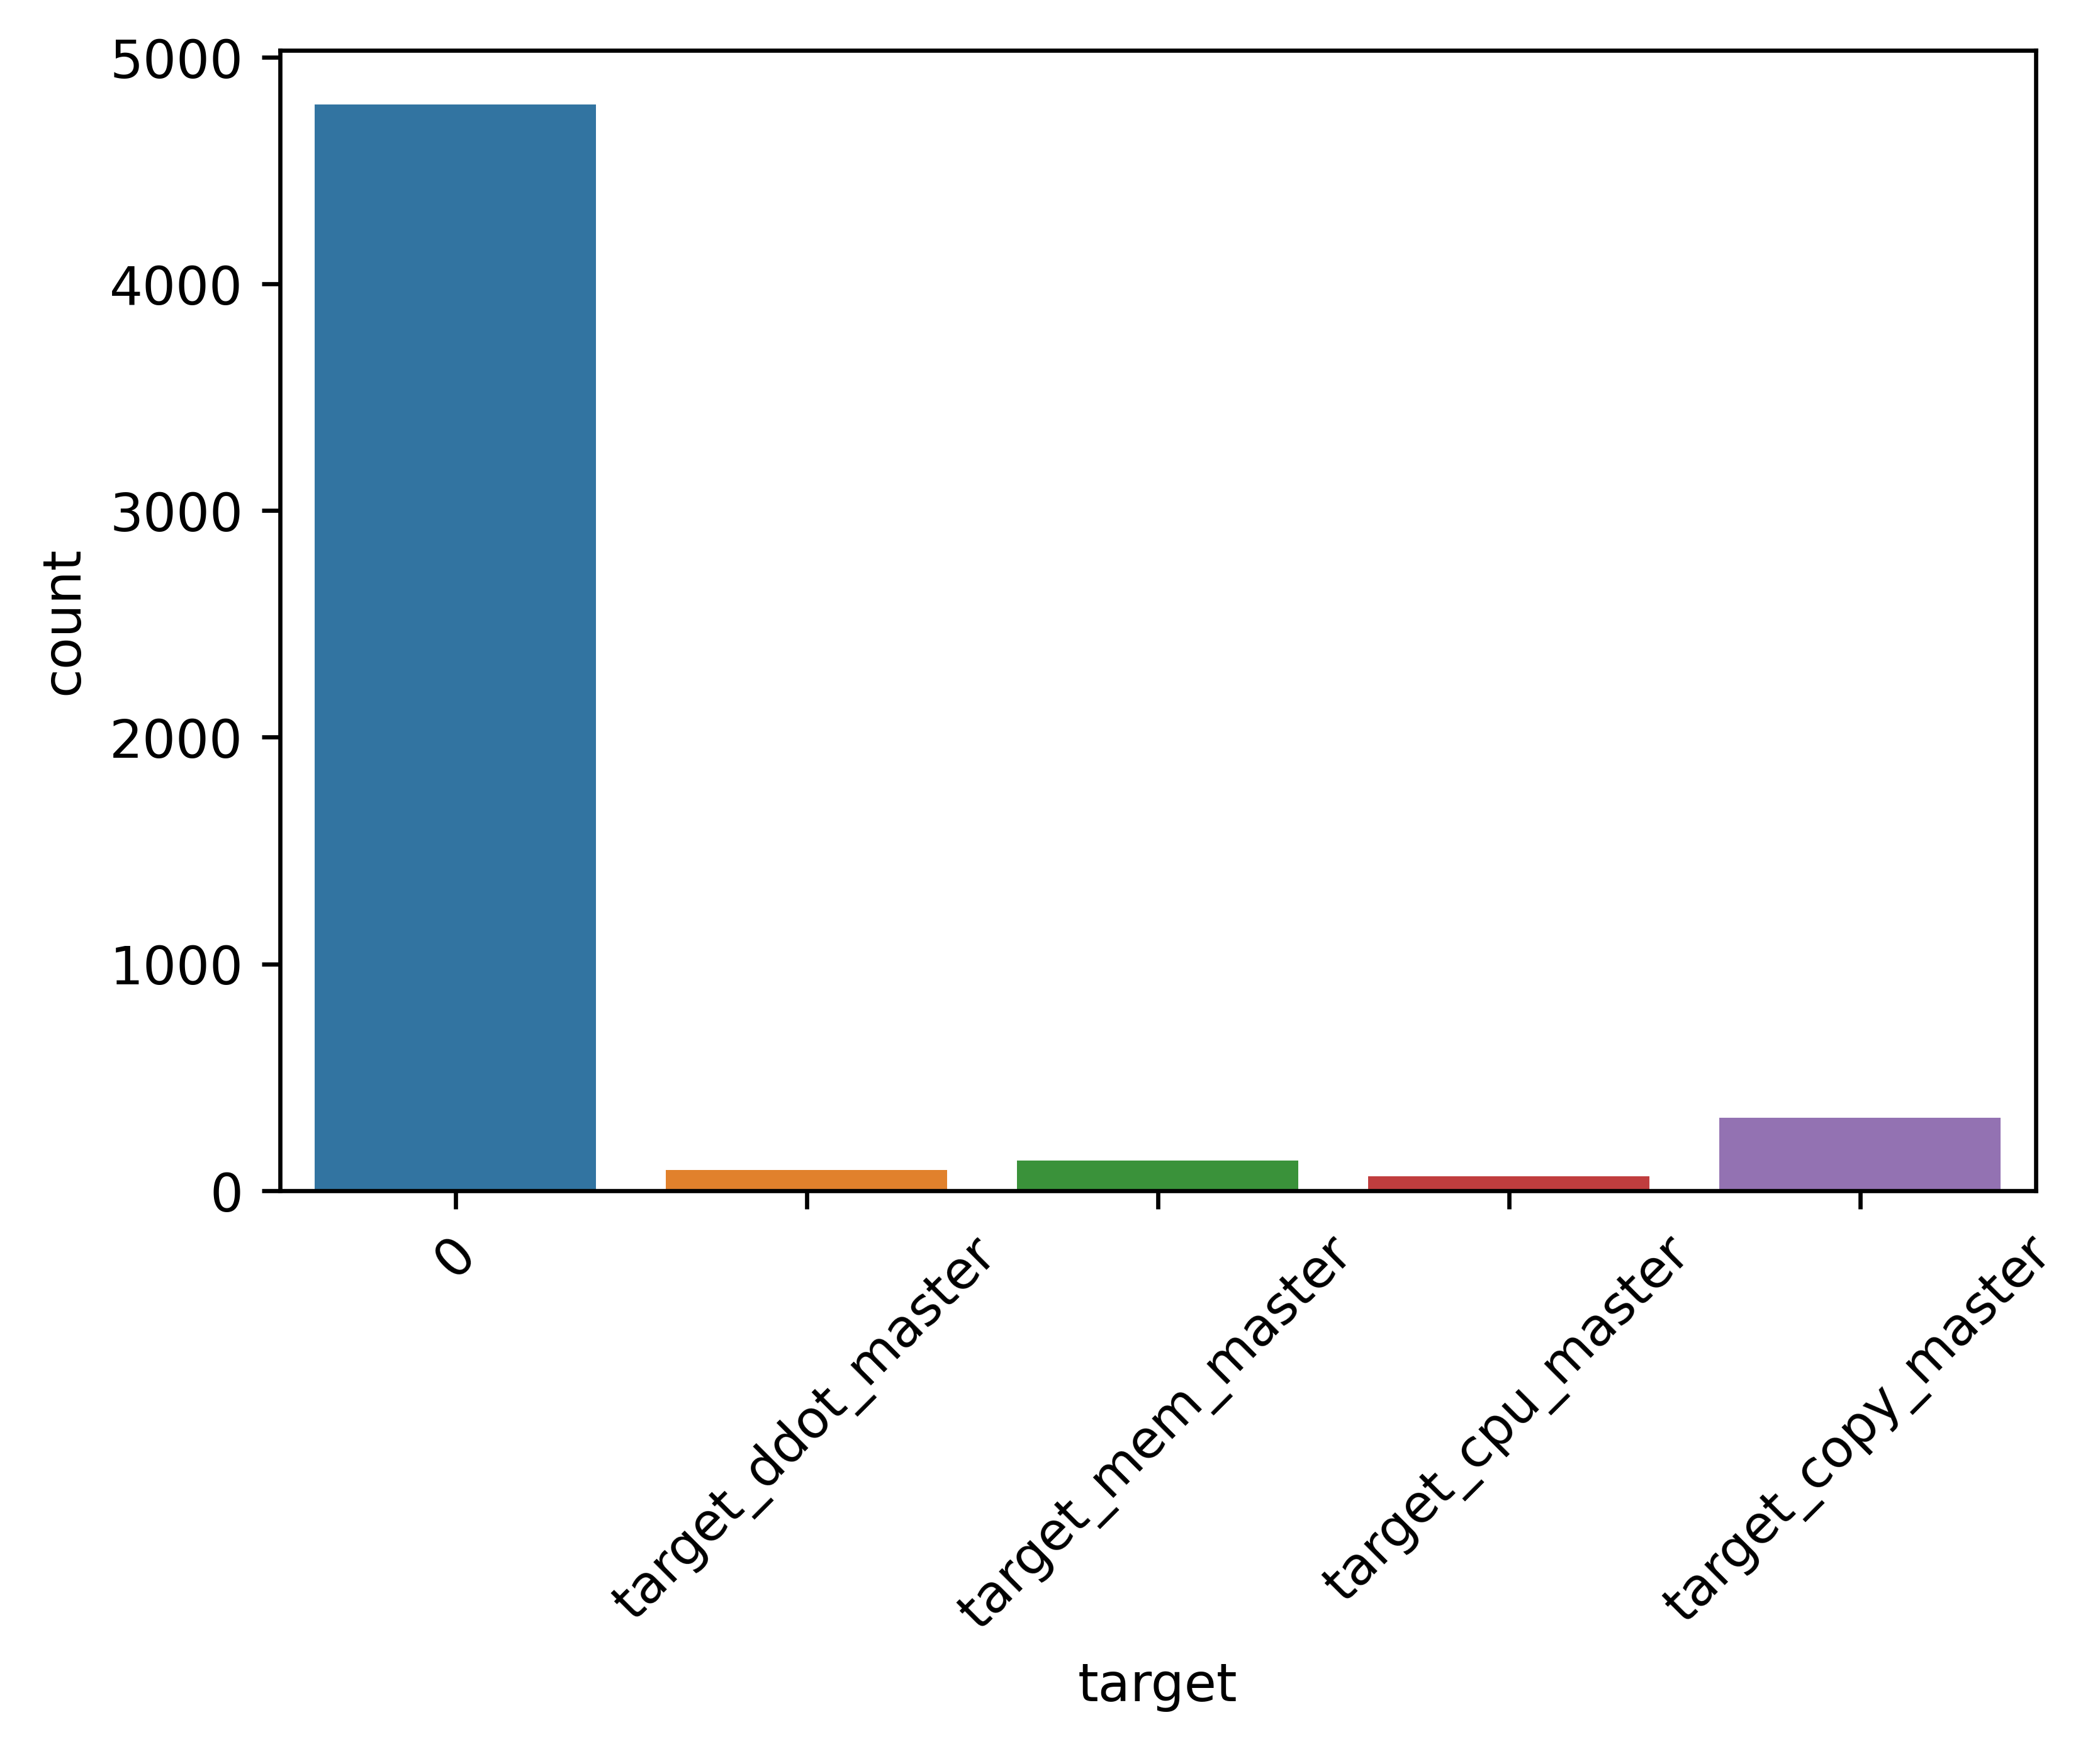

In [5]:
# Plot class distribution
print("Ploting class distribution ..")
plt.figure( dpi=600) #For publication only
class_dist_plot = sns.countplot(nice_y)
class_dist_plot.set_xticklabels(class_dist_plot.get_xticklabels(), rotation=45)
fig_cd = class_dist_plot.get_figure()
fig_cd.savefig(os.path.join(model_dir,"class_dist_single_anomaly.png"), bbox_inches='tight')

In [6]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


In [7]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) #

Scaling dataset


In [8]:
# XGBoost best performing

params = {"n_estimators": 10,
          "max_depth": 25,
          "learning_rate": 0.15,
          "subsample": 1.0,
          "min_child_weight": 1,
          "gamma": 1,
          "seed": 42,
          "objective": "multi:softmax",
          "n_jobs": -1,
          # "silent": True
          "use_label_encoder": False,
          "num_class": 5,
          }


clf = xgb.XGBClassifier(**params)

Starting fold 1
Scaling data ....
Start training ....
[15:20:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Predicting ....
----------------------------------------------------------------------------------------------------
Accuracy score fold 1 is: 0.9940740740740741
Ballanced accuracy fold 1 score is: 0.9625767968573007
Jaccard score fold 1: 0.9882179675994109
Full classification report for fold 1
                    precision    recall  f1-score   support

                 0     0.9958    0.9992    0.9975      1198
target_ddot_master     1.0000    0.9565    0.9778        23
 target_mem_master     0.9697    0.9697    0.9697        33
 target_cpu_master     0.9375    0.9375    0.9375        16
target_copy_master     0.9870    0.9500    0.9682        80

          accuracy                 

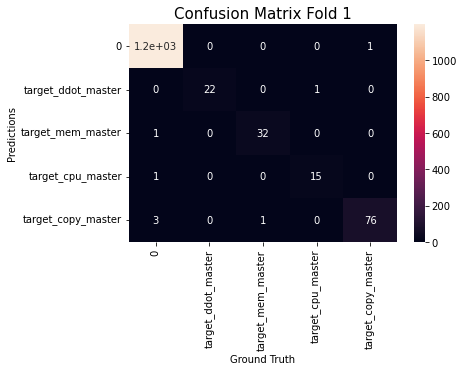

Extracting Feature improtance ...


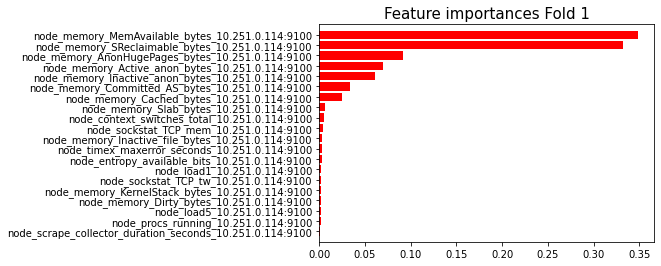

####################################################################################################
Starting fold 2
Scaling data ....
Start training ....
[15:20:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Predicting ....
----------------------------------------------------------------------------------------------------
Accuracy score fold 2 is: 0.997037037037037
Ballanced accuracy fold 2 score is: 0.9564393939393939
Jaccard score fold 2: 0.9940915805022157
Full classification report for fold 2
                    precision    recall  f1-score   support

                 0     1.0000    1.0000    1.0000      1198
target_ddot_master     0.9200    1.0000    0.9583        23
 target_mem_master     0.9697    0.9697    0.9697        33
 target_cpu_master     0.9286    0.8125    0.8667       

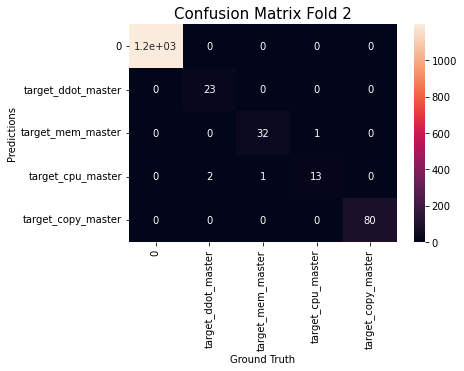

Extracting Feature improtance ...


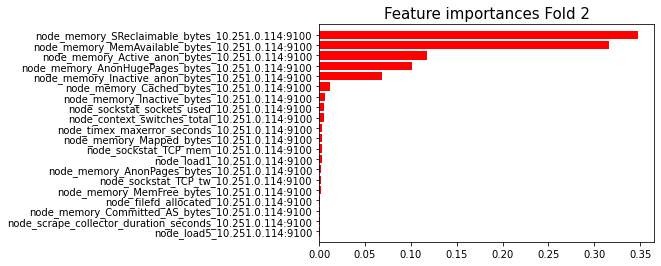

####################################################################################################
Starting fold 3
Scaling data ....
Start training ....
[15:20:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Predicting ....
----------------------------------------------------------------------------------------------------
Accuracy score fold 3 is: 0.9948148148148148
Ballanced accuracy fold 3 score is: 0.9450767968573006
Jaccard score fold 3: 0.9896831245394252
Full classification report for fold 3
                    precision    recall  f1-score   support

                 0     0.9983    0.9992    0.9987      1198
target_ddot_master     0.9167    0.9565    0.9362        23
 target_mem_master     1.0000    0.9697    0.9846        33
 target_cpu_master     0.9286    0.8125    0.8667      

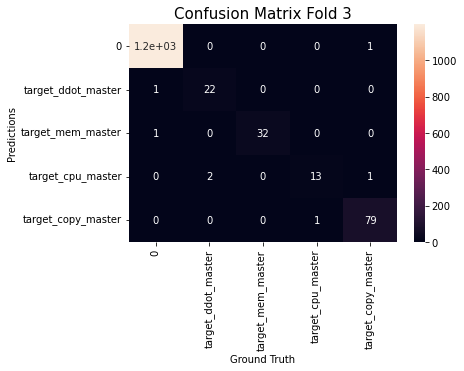

Extracting Feature improtance ...


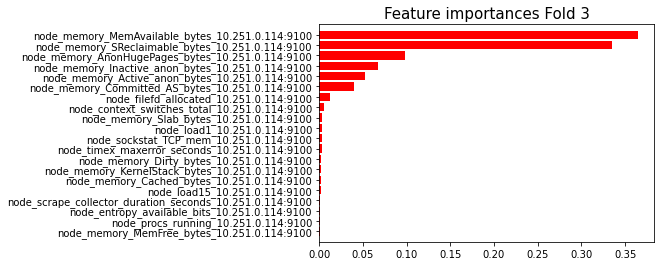

####################################################################################################
Starting fold 4
Scaling data ....
Start training ....
[15:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Predicting ....
----------------------------------------------------------------------------------------------------
Accuracy score fold 4 is: 0.9948148148148148
Ballanced accuracy fold 4 score is: 0.926548089591568
Jaccard score fold 4: 0.9896831245394252
Full classification report for fold 4
                    precision    recall  f1-score   support

                 0     0.9975    1.0000    0.9987      1198
target_ddot_master     0.8750    0.9130    0.8936        23
 target_mem_master     0.9697    0.9697    0.9697        33
 target_cpu_master     1.0000    0.7500    0.8571       

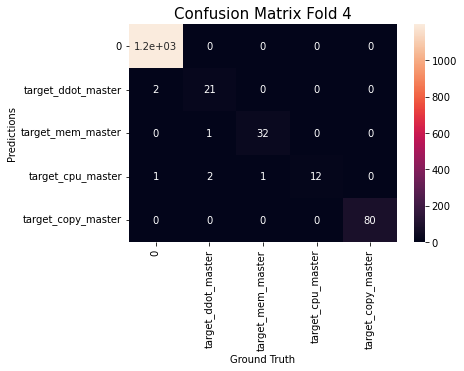

Extracting Feature improtance ...


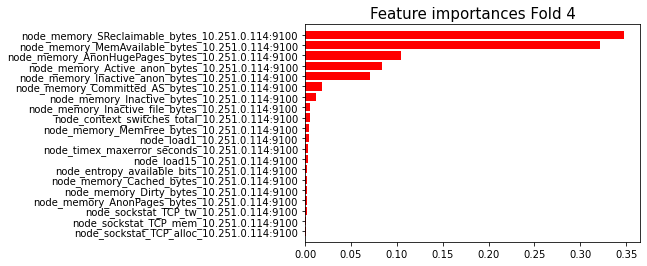

####################################################################################################
Starting fold 5
Scaling data ....
Start training ....
[15:20:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Predicting ....
----------------------------------------------------------------------------------------------------
Accuracy score fold 5 is: 0.9925925925925926
Ballanced accuracy fold 5 score is: 0.9540161907966945
Jaccard score fold 5: 0.9852941176470589
Full classification report for fold 5
                    precision    recall  f1-score   support

                 0     0.9975    0.9992    0.9983      1198
target_ddot_master     0.9565    0.9565    0.9565        23
 target_mem_master     0.9118    0.9394    0.9254        33
 target_cpu_master     0.8824    0.9375    0.9091      

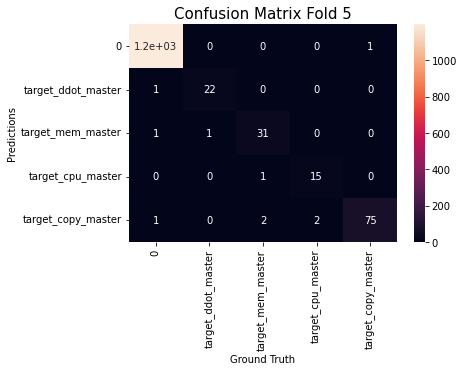

Extracting Feature improtance ...


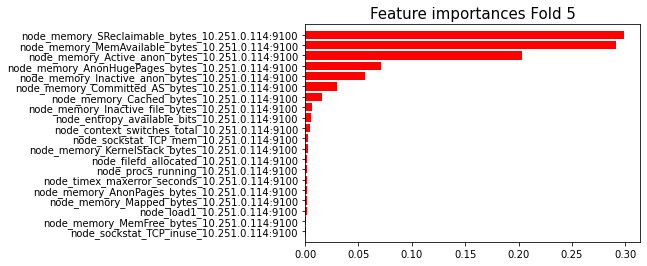

####################################################################################################


In [9]:
# skFold = StratifiedKFold(n_splits=5)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=21)
ml_method = 'xgb_best_cfg_anomaly_only_as_v1_test'
print("="*100)
clf_models = []
report = {
    "Accuracy": [],
    "BallancedAccuracy": [],
    "Jaccard": []
}
fold = 1
for train_index, test_index in sss.split(X, y):
    # print("Train:", train_index, "Test:", test_index)
    print("Starting fold {}".format(fold))
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    print("Scaling data ....")
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    print("Start training ....")
    clf.fit(Xtrain, ytrain)
    # Append model
    clf_models.append(clf)
    print("Predicting ....")
    ypred = clf.predict(Xtest)
    print("-"*100)
    acc = accuracy_score(ytest, ypred)
    report['Accuracy'].append(acc)
    print("Accuracy score fold {} is: {}".format(fold, acc))
    bacc = balanced_accuracy_score(ytest, ypred)
    report['BallancedAccuracy'].append(bacc)
    print("Ballanced accuracy fold {} score is: {}".format(fold, bacc))
    jaccard = jaccard_score(ytest, ypred, average='micro')
    print("Jaccard score fold {}: {}".format(fold, jaccard))
    report['Jaccard'].append(jaccard)

    ###
    print("Full classification report for fold {}".format(fold))
    print(classification_report(ytest, ypred, digits=4,target_names=definitions))

    cf_report = classification_report(ytest, ypred, output_dict=True, digits=4, target_names=definitions)
    df_classification_report = pd.DataFrame(cf_report).transpose()
    print("Saving classification report")
    classification_rep_name = "classification_{}_fold_{}.csv".format(ml_method, fold)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    ###
    print("Imbalanced Classification report for fold {}".format(fold))
    print(classification_report_imbalanced(ytest, ypred, digits=4, target_names=definitions))
    imb_cf_report = classification_report_imbalanced(ytest, ypred, output_dict=True, digits=4, target_names=definitions)
    df_imb_classification_report = pd.DataFrame(imb_cf_report).transpose()
    print("Saving imbalanced classification report")
    imb_classification_rep_name = "imb_classification_{}_fold_{}.csv".format(ml_method, fold)
    df_imb_classification_report.to_csv(os.path.join(model_dir,imb_classification_rep_name), index=False)
    ###
    print("Generating confusion matrix fold {}".format(fold))
    cf_matrix = confusion_matrix(ytest, ypred)

    # plt.figure(figsize=(10,20), dpi=600) For publication only
    ht_cf=sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
    plt.title('Confusion Matrix Fold {}'.format(fold), fontsize = 15) # title with fontsize 20
    plt.xlabel('Ground Truth', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('Predictions', fontsize = 10) # y-axis label with fontsize 15
    cf_fig = "CM_{}_{}.png".format(ml_method, fold)
    ht_cf.figure.savefig(os.path.join(model_dir, cf_fig), bbox_inches='tight')
    plt.show()


    print("Extracting Feature improtance ...")
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    sorted_feature = feat_importances.sort_values(ascending=True)
    # print(sorted_feature.head(-10))
    # print(type(sorted_feature.tail(15)))
    # print(X.shape[1])

    # Number of columns
    # print(len(sorted_feature))

    # Limit number of sorted features
    sorted_feature = sorted_feature.tail(20)



    # n_col = X.shape[1]
    n_col = len(sorted_feature)

    # Plot the feature importances of the forest
    # plt.figure(figsize=(10,20), dpi=600) For publication only
    plt.title("Feature importances Fold {}".format(fold), fontsize = 15)
    plt.barh(range(n_col), sorted_feature,
           color="r", align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(n_col), sorted_feature.index)
    plt.ylim([-1, n_col])
    fi_fig = "FI_{}_{}.png".format(ml_method, fold)
    plt.savefig(os.path.join(model_dir, fi_fig), bbox_inches='tight')
    plt.show()
    #increment fold count
    fold+=1
    print("#"*100)

In [10]:
print("Saving final report ...")
# Validation Report
df_report = pd.DataFrame(report)
final_report = "Model_{}_report.csv".format(ml_method)
df_report.to_csv(os.path.join(model_dir,final_report), index=False)

Saving final report ...


In [11]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve, RFECV
plt.figure(dpi=600) #For publication only
sss.split(X, y)
sizes = np.linspace(0.3, 1.0, 10)
viz = LearningCurve(clf, cv=sss, scoring='f1_weighted', train_sizes=sizes, n_jobs=-1)
viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_learningcurve.png"))

ImportError: cannot import name 'safe_indexing' from 'sklearn.utils' (/Users/Gabriel/anaconda3/envs/p3envmlv3/lib/python3.8/site-packages/sklearn/utils/__init__.py)

In [ ]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = [10, 60, 100, 200, 600, 1000, 2000]
plt.figure( dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="n_estimators", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_n_estimators_validationcurve.png"))
viz.get_params()

In [ ]:
save_valid_curve_scores(viz,"n_estimators",param_range,ml_method)

In [ ]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = [3, 4, 6, 25, 50]
plt.figure( dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="max_depth", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_max_depth_validationcurve.png"))
# viz.get_params()

In [ ]:
save_valid_curve_scores(viz,"max_depth",param_range,ml_method)

In [ ]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 0.9]
plt.figure( dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="learning_rate", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_learning_rate_validationcurve.png"))
# viz.get_params()

In [ ]:
save_valid_curve_scores(viz,"learning_rate",param_range,ml_method)

In [ ]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = [0.2, 0.5, 1]
plt.figure( dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="subsample", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_subsample_validationcurve.png"))
# viz.get_params()

In [ ]:
save_valid_curve_scores(viz,"subsample",param_range,ml_method)

In [ ]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = [1, 2, 5, 6, 10]
plt.figure( dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="min_child_weight", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_min_child_weight_validationcurve.png"))
# viz.get_params()

In [ ]:
save_valid_curve_scores(viz,"min_child_weight",param_range,ml_method)

In [ ]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve
param_range = [0, 0.1, 1]
plt.figure( dpi=600) #For publication only
viz = ValidationCurve(
    clf, param_name="gamma", param_range=param_range,
    logx=True, cv=sss, scoring="f1_weighted", n_jobs=-1,
)

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_gamma_validationcurve.png"))
# viz.get_params()

In [ ]:
save_valid_curve_scores(viz,"gamma",param_range,ml_method)

In [ ]:
from yellowbrick.model_selection import LearningCurve, ValidationCurve, RFECV

plt.figure(dpi=600) #For publication only
#had to remove max feature 50 to high
params_2 =  {
    "n_estimators": 10,
    "max_depth": 25,
    "learning_rate": 0.15,
    "subsample": 1.0,
    "min_child_weight": 1,
    "gamma": 1,
    "seed": 42,
    "objective": "multi:softmax",
    "n_jobs": -1,
    # "silent": True
             }

clf_2 = xgb.XGBClassifier(**params_2)
viz = RFECV(clf_2, cv=sss, scoring="f1_weighted")

viz.fit(X, y)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_recursivefeatureelimination.png"))

In [ ]:
# Save features to drop and features to keep
df_features_rfe = pd.DataFrame({
    "Features": X.columns,
    "Include": viz.support_
})

# Features to be included after rfe
df_features_rfe_include = df_features_rfe.loc[df_features_rfe['Include'] == True]
df_features_rfe_drop = df_features_rfe.loc[df_features_rfe['Include'] == False]

df_features_rfe_include.to_csv(os.path.join(model_dir, f"{ml_method}_rfe_include.csv"), index=False)
df_features_rfe_drop.to_csv(os.path.join(model_dir, f"{ml_method}_rfe_drop.csv"), index=False)

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC
plt.figure(dpi=600) #For publication only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
params_3 =  {
    "n_estimators": 10,
    "max_depth": 25,
    "learning_rate": 0.15,
    "subsample": 1.0,
    "min_child_weight": 1,
    "gamma": 1,
    "seed": 42,
#     "objective": "multi:softmax", # xgb model is Wrapped as a OneVsRestClassifier thus ouput has the shape (nr_datapoints, num_classes) instead of just (nr_datapoints) for xgb version >0.90
    "eval_metric": "merror",
    "n_jobs": -1,
#     "num_class": 5,
    "use_label_encoder": False
             }
clf_3 = xgb.XGBClassifier(**params_3)
viz = PrecisionRecallCurve(clf_3, per_class=True, cmap="Set1", classes=definitions)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_precisionrecallcurve.png"))

In [ ]:
viz = PrecisionRecallCurve(
    clf_3,
    classes=definitions,
    colors=["purple", "cyan", "blue", "red", "green"],
    iso_f1_curves=True,
    per_class=True,
    micro=False,
)
plt.figure(dpi=600) #For publication only
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_learningcurve_pretty.png"))

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC
viz = ROCAUC(estimator=clf, classes=definitions, is_fitted=True)
plt.figure(dpi=600) #For publication only
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show(outpath=os.path.join(model_dir, f"{ml_method}_ROCAUC.png"))

Scoring on holdout or other dataset

In [ ]:
def compare_to_holdout(df_data,
                       model,
                       definitions,
                       scaler=None,
                       clean=False,
                       prefix='rf_holdout'):
    #Creating the dependent variable class
    factor_h = pd.factorize(df_data['target'])
    df_data.target = factor_h[0]
    definitions_test_data = factor_h[1]
    print("Splitting dataset into data and ground truth ...")
    X_h = df_data.drop('target', axis=1)
    y_h = df_data['target']
    # Scale same as original dataset
    if scaler is None:
        scaler = MinMaxScaler()
    X_h = scaler.fit_transform(X_h)  # scaler only used on a per fold basis may cause error on entire dataset.
    # Select model from split to be tested
    y_pred_h = model.predict(X_h)


    # Recompute custom definitions in case of mismath
    if len(list(np.unique(y_pred_h))) != len(definitions) and clean:
        print(f"Prediction contains the following classes: {list(np.unique(y_pred_h))}")
        target_names = []
        for t in list(np.unique(y_pred_h)):
            target_names.append(definitions[t])
        print(f"Mapped to: {target_names}")
    else:
        target_names = definitions
    # print(classification_report(y_h, y_pred_h, target_names=target_names))
    # print(classification_report(y_h, y_pred_h, target_names=target_names))
    # print(classification_report_imbalanced(y_h, y_pred_h), target_names=list(np.unique(y_pred_h)))
    custom_scoring_reporting(y_pred_h, y_h, definitions=target_names, prefix=prefix)

    print(f"Instances predicted by class:")
    print(f"{df_data}")
    if clean:
        cls, count =  np.unique(y_pred_h, return_counts=True)
    else:
        count = np.bincount(y_pred_h)
    print(pd.DataFrame({"Classes": target_names, "Predictions": count}))


    print("Generating confusion matrix for holdout")
    cf_matrix = confusion_matrix(y_h, y_pred_h)
    # plt.figure(figsize=(10,20), dpi=600) For publication only
    ht_cf=sns.heatmap(cf_matrix, annot=True, yticklabels=list(target_names), xticklabels=list(target_names))
    plt.title('Confusion Matrix Holdout set', fontsize = 15) # title with fontsize 20
    plt.xlabel('Ground Truth', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('Predictions', fontsize = 10) # y-axis label with fontsize 15
    cf_fig = "CM_{}_{}.png".format(ml_method, prefix)
    ht_cf.figure.savefig(os.path.join(model_dir, cf_fig),  bbox_inches='tight')
    plt.show()
    return y_pred_h, y_h.values, target_names

In [ ]:
prefix_name = "xgb_holdout"

y_pred_h, y_h , target_names = compare_to_holdout(df_audsome,  clf_models[0], definitions=definitions, clean=False, prefix=prefix_name)

In [ ]:
# #Creating the dependent variable class
# factor_h = pd.factorize(df_audsome['target'])
# df_audsome.target = factor_h[0]
# definitions_h = factor_h[1]

In [206]:
# print("Splitting dataset into data and ground truth ...")
# X_h = df_audsome.drop('target', axis=1)
# y_h = df_audsome['target']

In [198]:
# # Scale same as original dataset
# X_h = scaler.transform(X_h)

In [199]:

# # Select model from split to be tested
# test_model = clf_models[3]
# y_pred_h = test_model.predict(X_h)
# #
#
#
#
# custom_scoring_reporting(y_pred_h, y_h, definitions, prefix="rf_holdout")